# Unet
source: https://amaarora.github.io/2020/09/13/unet.html

<img src="https://i.imgur.com/LQORH9i.png" alt="drawing" width="500"/>


In [38]:
BATCH_SIZE = 32
BATCH = 4
NUM_LABELS = 1
WIDTH = 128
HEIGHT = 128

In [39]:
import cv2
import torch # 1.9
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import os
import torch.optim as optim

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
import os   
cmd = '''wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxvf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' # for debug
device

device(type='cuda')

### ConvBlock

In [43]:
# class convBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#         self.relu  = nn.ReLU()
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
#     def forward(self, x):
#         return self.relu(self.conv2(self.relu(self.conv1(x))))

In [44]:
class convBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.INorm = torch.nn.InstanceNorm2d(NUM_LABELS)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.INorm(x)
        x = self.relu(self.conv2(x))
        x = self.INorm(x)
        return x

In [45]:
block = convBlock(1, 64)
x = torch.randn(1, 1, WIDTH, HEIGHT)
block(x).shape

torch.Size([1, 64, 128, 128])

## Encoder(DownStream)
將影像進行編碼，過程中解析度會縮小(maxpooling、convolution)

In [46]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,32,64,128,256,512)):
        super().__init__()
        self.list_of_blocks = nn.ModuleList([convBlock(chs[i], chs[i+1]) for i in range(len(chs)-1)])
#         self.pool = nn.MaxPool2d(2)
        self.pool = torch.max_pool2d
        
    def forward(self, x):
        features = []
        
        for block in self.list_of_blocks:
            x = block(x)
            features.append(x)
#             print(x.shape)
            x = self.pool(x, kernel_size=2)
        return features

In [47]:
encoder = Encoder()
x = torch.randn(1, 3, WIDTH, HEIGHT)
features = encoder(x)
for f in features:
    print(f.shape)

torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 512, 8, 8])


## Decoder(UpStream)
將編碼還原成影像，過程中解析度會放大直到回復成輸入影像解析度(transposed Convolution)。
- 將編碼還原成影像是因為影像分割是pixel-wise的精度進行預測，解析度被還原後，就可以知道指定pixel位置所對應的類別
- 類別資訊通常用feature-map的channels(chs)去劃分，一個channel代表一個class
- 有許多UNet模型架構會有輸入576x576，但輸出只有388x388的情況，是因為他們沒有對卷積過程做padding，導致解析度自然下降。最後只要把mask resize到388x388就能繼續計算loss。

### Transposed Conv操作
<img src="https://i.imgur.com/eIIJxre.png" alt="drawing" width="300"/>
<img src="https://i.imgur.com/uLo7icF.png" alt="drawing" width="300"/>

<!-- #### 替代方案 UpSampling(Unpooling)+Convolution -->


In [48]:
# ConvTranspose2d透過設定k=2, s=2, output_padding=0可以讓影像從28x28變成56x56
x = torch.randn(1, 3, 28, 28)
x = nn.ConvTranspose2d(3, 30, kernel_size=2, stride=2, output_padding=0)(x)
x.shape

torch.Size([1, 30, 56, 56])

### UpsampleConv
- 先做上採樣(Upsample/ Unpooling)
- 然後作卷積(padding = same)

In [49]:
class upSampleConvs(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
#         self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = nn.ReLU()
        self.upSample = nn.Upsample(scale_factor=2)
        self.conv2 = nn.Conv2d(in_ch, out_ch, 2, padding='same')
        self.INorm = torch.nn.InstanceNorm2d(NUM_LABELS)
        
    def forward(self, x):
        x = self.upSample(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.INorm(x)
#         return self.relu(self.conv2(self.relu(self.upSample(x))))
        return x

In [50]:
x = torch.randn(1, 3, 28, 28)
x = upSampleConvs(3,30)(x)
x.shape

torch.Size([1, 30, 56, 56])

### decoder(上採樣) module

In [51]:
class Decoder(nn.Module):
    def __init__(self, chs=(512, 256, 128, 64, 32)):
        super().__init__()
        self.chs = chs
#         self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.upconvs = nn.ModuleList([upSampleConvs(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.list_of_convBlock = nn.ModuleList([convBlock(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x = x
            enc_ftrs = encoder_features[i]
            enc_ftrs = enc_ftrs
            
            x = self.upconvs[i](x)

            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.list_of_convBlock[i](x)
        return x

In [52]:
for i in features:
    print(i.shape)

torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 512, 8, 8])


In [53]:
decoder = Decoder()
decoder
x = torch.randn(1, 512, WIDTH//16, HEIGHT//16)
decoder(x, features[::-1][1:]).shape 

torch.Size([1, 32, 128, 128])

## Unet構建
結合encoder和decoder組成Unet。
- 在輸出層如果用softmax做多元分類問題預測的話，類別數量要+1(num_classes+background)

In [54]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(256,256)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:]) # 把不同尺度的所有featuremap都輸入decoder，我們在decoder需要做featuremap的拼接
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [55]:
unet = UNet(num_class=1)
unet.to(device)
x    = torch.randn(1, 3, WIDTH, HEIGHT).to(device)
unet(x).shape

torch.Size([1, 1, 128, 128])

## Test on dataset

In [56]:
def show_image_mask(*img_):
    plt.figure(figsize=(10,3))
    for i, img in enumerate(list(img_), 1):
#         print(np.shape(img))
        plt.subplot(1,len(img_),i)
        if len(np.shape(img)) == 2 or np.shape(img)[-1] == 1:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
    plt.show()
    plt.close()

In [59]:
os.getcwd()

'/home/jovyan/git/tmp/Image_Segmentation/Unet'

In [60]:
item = 'capsule'
path = os.getcwd()
img_dir = f'{path}/data/{item}/test/scratch/'
print(len(os.listdir(img_dir)))
anno_dir = f'{path}/data/{item}/ground_truth/scratch/'

defective_number = [i.split('.')[0] for i in os.listdir(img_dir)]

23


### get image list

In [247]:
from sklearn.model_selection import train_test_split
mask_dir = lambda anno_dir, X_lis:[anno_dir+i.split('.')[0]+'_mask.png' for i in X_lis]

imgs_path_list = sorted(os.listdir(img_dir))

train, test = train_test_split(imgs_path_list, train_size = 1/len(imgs_path_list))

key = 'X_train, X_test, y_train, y_test'.split(', ')

lis = []
for number in [train, test]:
    lis.append([img_dir+i for i in number]) # X
for number in [train, test]:
    lis.append(mask_dir(anno_dir, number)) # y
data_dic = dict(zip(key, lis))
data_dic['X_train']

['/home/jovyan/git/tmp/Image_Segmentation/Unet/data/capsule/test/scratch/009.png']

### Build torch dataset

In [248]:
#  https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomImageDataset(Dataset):
    def __init__(self, imgs_path_list, anno_path_list, transform=None, target_transform=None):
        self.imgs_path_list = imgs_path_list
        self.anno_path_list = anno_path_list
        if type(imgs_path_list) != list:
            raise ValueError('Need Input a list')
        if type(anno_path_list) != list:
            raise anno_path_list('Need Input a list')
        self.transform = transform
#   
    def __len__(self):
        return len(self.imgs_path_list)
#         return 32

    def __getitem__(self, idx):
        img_path = self.imgs_path_list[idx]
        file_name = img_path.split('/')[-1].split('.')[0]
        mask_path = [i for i in self.anno_path_list if i.__contains__(file_name)][0]
        
        # cv2
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#       
        # cv2
        mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            transformed = transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
        return image, mask
    

In [302]:
data_dic['X_train']

['/home/jovyan/git/tmp/Image_Segmentation/Unet/data/capsule/test/scratch/009.png']

(1000, 1000, 3)
(1000, 1000)


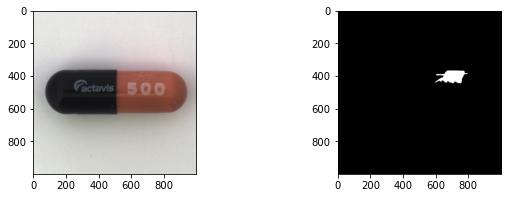

In [304]:
a = CustomImageDataset(data_dic['X_train'], data_dic['y_train'])
test_image = a.__getitem__(0)[0]
test_mask = a.__getitem__(0)[1]
print(test_image.shape)
print(test_mask.shape)
show_image_mask(test_image, test_mask)

[675.11673152 410.71206226]
4 POINTS / WIDTH + pad [561 297 789 525] 228


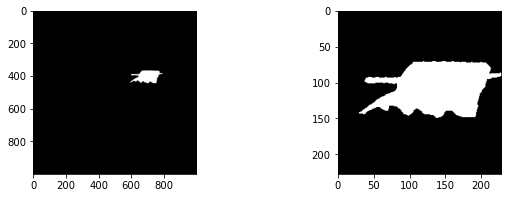

In [335]:
def find_objects_contours(mask):
    thresh = mask
    contours, hier = \
        cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    np.shape(contours)

    arr = np.array(contours).reshape(-1,2)
    arr = arr.mean(axis=0)
    return arr
def center_to_4point(mask, arr, side_width, pad=25):
    limit = len(mask)
    points = [0]*4
    
    if not pad:
        pad = 0
    value = side_width/2+pad    
    for i in arr:
        if side_width+2*pad > limit:
            print(side_width+2*pad)
            raise ValueError('not enough')
        if i > limit:
            raise ValueError('not include')
            
    for i in range(len(points)):
        if i in [0,1]:
            if arr[i%2] - value < 0:
                points[i] = 0
                points[i+2] += np.abs(arr[i%2] - value)
            else:
                points[i] = arr[i%2]-value
        if i in [2,3]:
            if arr[i%2]+value > limit:
                print(arr[i%2]+value)
                points[i] = len(mask)
                points[i-2] -= np.abs(limit - arr[i%2] - value)
            else:
                points[i] = arr[i%2]+value
    
    return np.round(points).astype(int)


#         if i in [0,1]:
#             points[i]  
arr = find_objects_contours(test_mask)
print(arr)
# plt.imshow(test_mask, cmap='gray')
points = center_to_4point(test_mask[:, :], arr, WIDTH, pad=50)
print('4 POINTS / WIDTH + pad', points, points[2]-points[0])
x_min, y_min, x_max, y_max = points
show_image_mask(test_mask, test_mask[y_min:y_max, x_min:x_max])

In [328]:
# https://albumentations.ai/docs/getting_started/mask_augmentation/

transform = A.Compose([
    A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, p=0.5),
#     A.CenterCrop(300, 900, p=0.8),
#     A.RandomCrop(width=WIDTH, height=HEIGHT, p=0.8),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
    A.Rotate((-30, 30), interpolation=0),  

    A.ToFloat(always_apply=True),
    A.Resize(WIDTH, HEIGHT),
])

# target_transform = A.Compose([
#     A.ToFloat(always_apply=True),
#     A.Resize(WIDTH, HEIGHT),
# ])

In [329]:
BATCH_SIZE = 10
MULTIPLE_BATCH = 1 # [MULTIPLE_BATCH>1]
dataset_train = CustomImageDataset(data_dic['X_train']*BATCH_SIZE, data_dic['y_train']*BATCH_SIZE, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
# dataloader_train = iter(dataloader_train)

dataset_test = CustomImageDataset(data_dic['X_test'], data_dic['y_test'], transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, drop_last=True, pin_memory=True)
# dataloader_test_iter = iter(dataloader_train)

torch.Size([128, 128, 3])
torch.Size([128, 128])


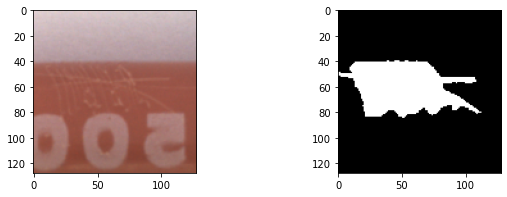

torch.Size([128, 128, 3])
torch.Size([128, 128])


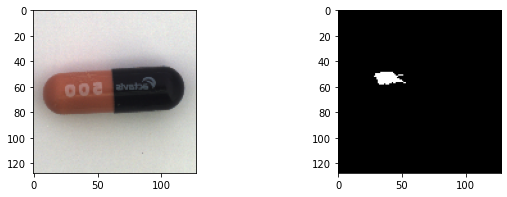

torch.Size([128, 128, 3])
torch.Size([128, 128])


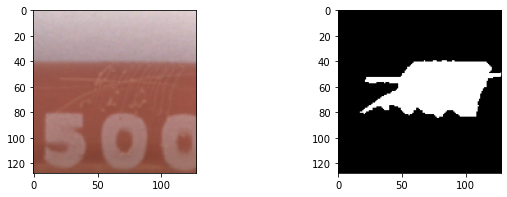

torch.Size([128, 128, 3])
torch.Size([128, 128])


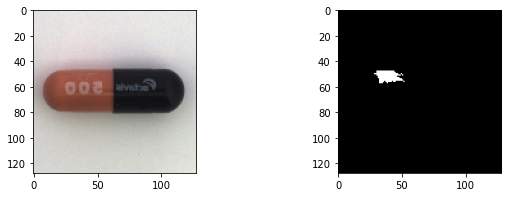

torch.Size([128, 128, 3])
torch.Size([128, 128])


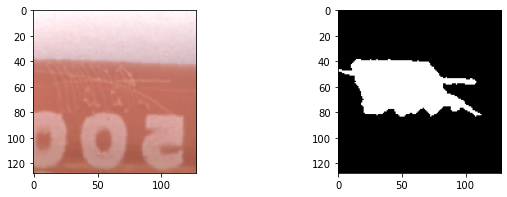

torch.Size([128, 128, 3])
torch.Size([128, 128])


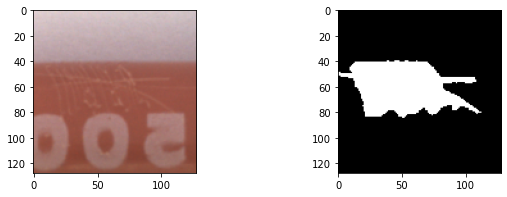

torch.Size([128, 128, 3])
torch.Size([128, 128])


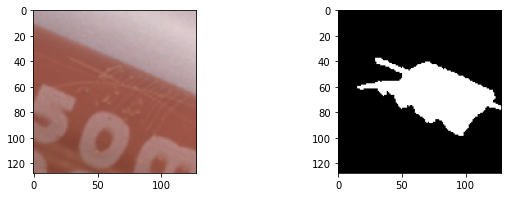

torch.Size([128, 128, 3])
torch.Size([128, 128])


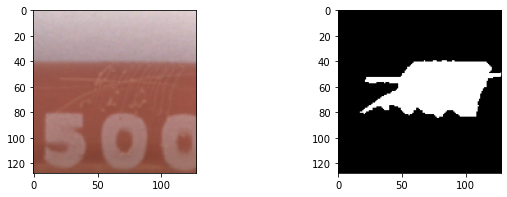

torch.Size([128, 128, 3])
torch.Size([128, 128])


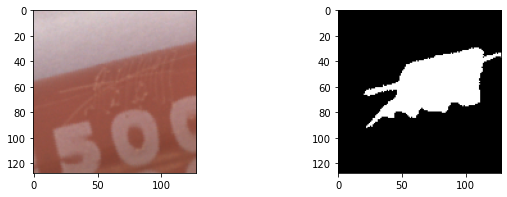

torch.Size([128, 128, 3])
torch.Size([128, 128])


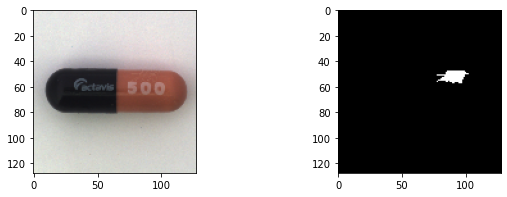

In [330]:
'''test transform on dataloader_train'''
for data in dataloader_train:
#     print(data.shape)
    for x, y in zip(*data):
        print(x.shape)
        print(y.shape)
        show_image_mask(x, y)

In [336]:
model = UNet(num_class=NUM_LABELS)
model.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([1000]).to(device))
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

# (optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [337]:
# model = torch.load('save.pt')

In [338]:
best_loss = None
# early_stop = False
VALUE = None
patience = VALUE
for epoch in range(3000//BATCH_SIZE):  # loop over the dataset multiple times
    torch.cuda.empty_cache()
    running_loss = 0.0
#     sample_i = 0
    
    multiple_inputs = torch.Tensor([])
    multiple_mask = torch.Tensor([])
    
    for multiple_batch in range(MULTIPLE_BATCH):
        for i, data in enumerate(dataloader_train, 1): # get each batch, setting drop_last
#             print(i, len(data))
            inputs, mask = data
#             print(len(inputs))
            multiple_inputs = torch.cat((multiple_inputs, inputs),
                                        dim=0)
            multiple_mask = torch.cat((multiple_mask, mask),
                                        dim=0)

#     print(multiple_inputs.shape)
#     print(multiple_mask.shape)
#     print(len(multiple_inputs))
    
    inputs = multiple_inputs.to(device)
    mask = multiple_mask.to(device)

#     print(inputs.shape)
    inputs = inputs.permute(0,3,1,2)
    mask = mask.unsqueeze(1)
    mask = mask.float()/255
#     print(mask.max())
#     print(inputs.shape)
#     print(mask.shape)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, mask)
    loss.backward()
    optimizer.step()
    
    # print statistics
    running_loss += loss.item()
#     if Per_epoch_samples*epoch % 100 == 1:    # print every 2000 mini-batches
#         print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#         running_loss = 0.0

    # 扣除patience
#     if patience:
    
    if patience == 0 and running_loss >= best_loss:
        print('early_stop')
        break

    if not best_loss:
        best_loss = running_loss
    elif running_loss < best_loss and best_loss <= 0.1*best_loss:
        best_loss = running_loss
        torch.save(model, 'save.pt')
        print('save torch model [save.pt]')
    elif running_loss < best_loss:
        best_loss = running_loss
        patience = VALUE
    
    if not patience and epoch == 0:
        print('No early stop')
    elif patience:
        patience -= 1
    

    
    print(f'epochs: {epoch}, average sample loss: {running_loss/len(multiple_inputs):.8f}')
#     print(f'[{epoch + 1}, {epoch*MULTIPLE_BATCH*BATCH_SIZE}] loss: {running_loss / 2000:.6f}')
    running_loss = 0.0

# torch.save(model, 'save.pt')
        
# print('Finished Training')

No early stop
epochs: 0, average sample loss: 7.39689560
epochs: 1, average sample loss: 3.58997917
epochs: 2, average sample loss: 2.69136353
epochs: 3, average sample loss: 2.60381355
epochs: 4, average sample loss: 1.60677910
epochs: 5, average sample loss: 1.17815676


KeyboardInterrupt: 

In [ ]:
test_set = iter(dataloader_train)

In [ ]:
image, mask = test_set.next()
print(image.shape)
mask.max()

torch.Size([16, 3, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
tensor(-42.0716, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


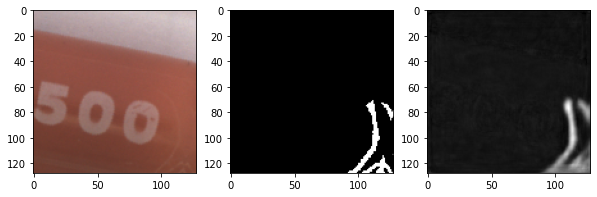

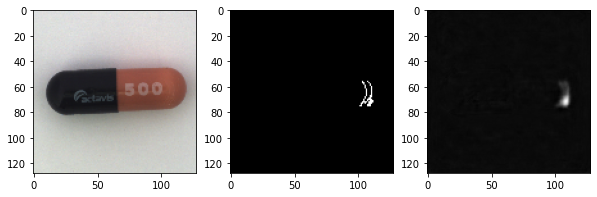

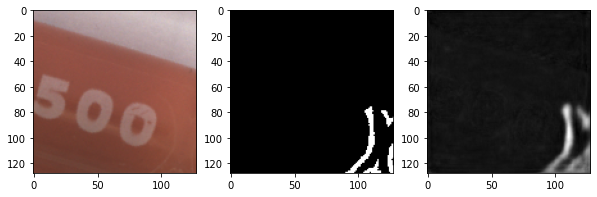

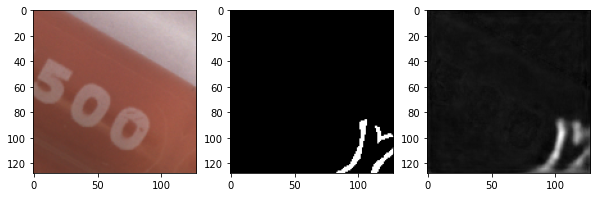

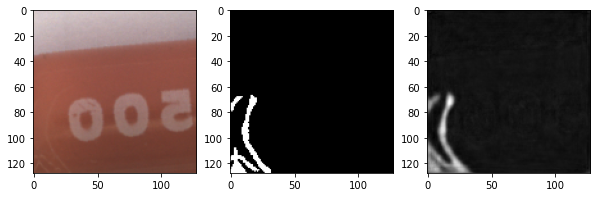

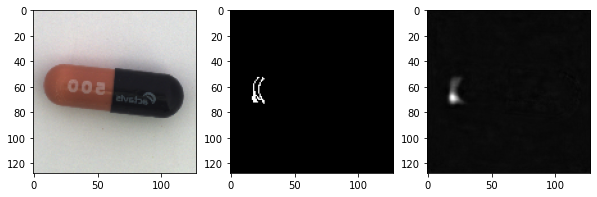

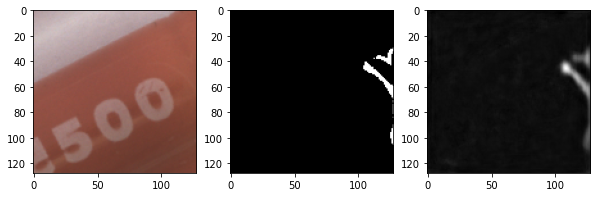

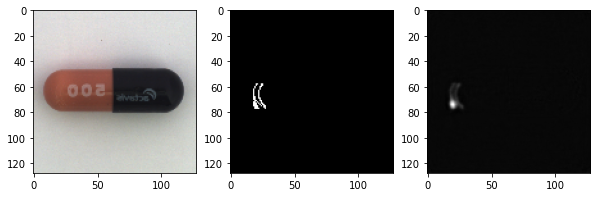

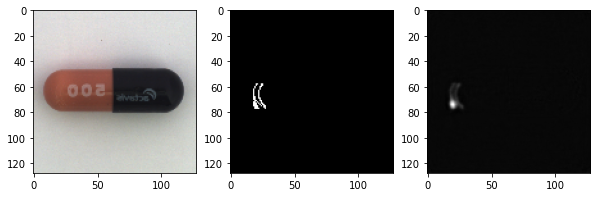

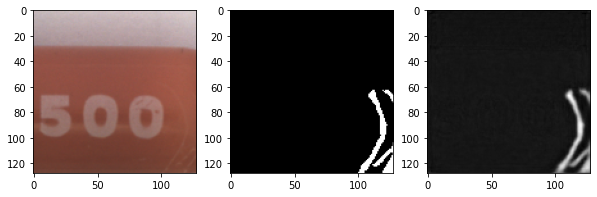

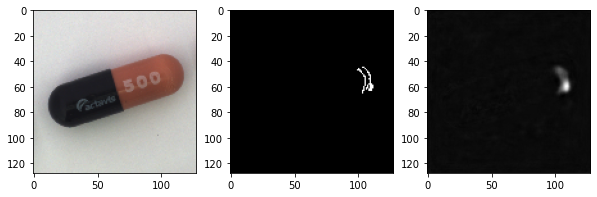

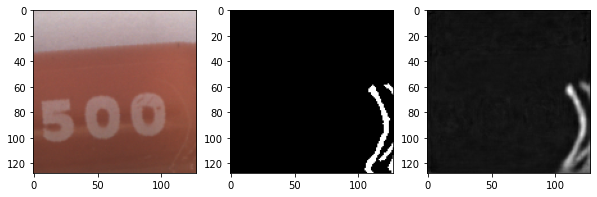

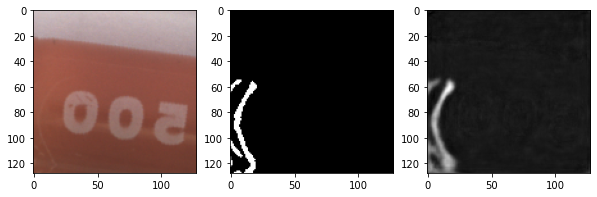

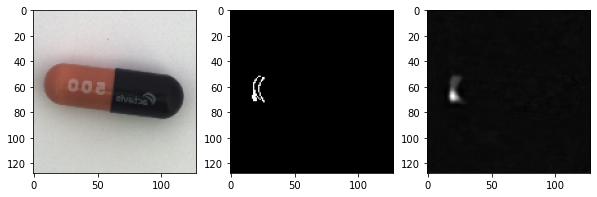

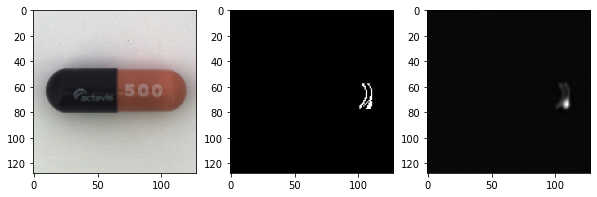

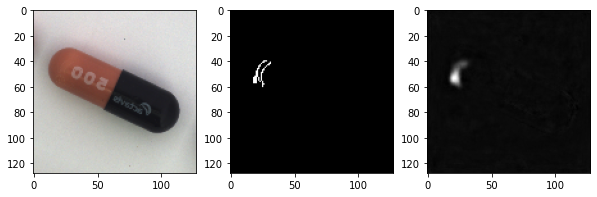

In [231]:
image = image.permute(0,3,1,2).to(device)
mask = mask.unsqueeze(1).to(device)
mask = mask.float()
print(image.shape)
print(mask.shape)

outputs = model(image)
print(outputs.shape)
loss = criterion(outputs, mask)
print(loss)


a = image.permute(0,2,3,1).squeeze(0).cpu().numpy()
b = mask.permute(0,2,3,1).squeeze(0).squeeze(-1).cpu().numpy()
# print(a.shape)
# for x,m in zip(a, b):
#     show_image_mask(x, m)
    

outputs = model(image)
# print(outputs.shape)
c = outputs.permute(0,2,3,1).squeeze(0).squeeze(-1).cpu().detach().numpy()
# b = mask.permute(0,2,3,1).squeeze(0).squeeze(-1).cpu().numpy()
# show_image_mask(a, b)
# print(a.shape)
# print(b.shape)
for x,m, p in zip(a, b, c):
    show_image_mask(x, m, p)

In [111]:
# single sample
# advance dilated/ upsampling
# another dataset

In [232]:
# from torch.datasets import OxfordIIITPet